In [3]:
import pandas as pd
import gensim
from gensim.models.coherencemodel import CoherenceModel

In [4]:
data = pd.read_csv("../../../nlp_poem.csv", index_col=False)
poem = data

,author,title,content
0,문정희,가을 노트,<br><br><br>그대 떠나간 후<br>나의 가을은<br>조금만 건드려도<br>...
1,이순,가을비 오는 날은,<br>자정이 되어 간신히 그치는 비<br>간신히 버리는 그리움<br>그동안 너무 ...
2,이성선,가을 편지,<br>잎이 떨어지고 있습니다<br>원고지처럼 하늘이 한 칸씩<br>비어 가고 있습...
3,박제영,가을에는,<br>가을에는 잠시 여행을 떠날 일이다<br>그리 수선스러운 준비는 하지 말고<b...
4,최영미,가을에는,<br>내가 그를 사랑한 것도 아닌데<br>미칠 듯 그리워질 때가 있다<br>바람의...


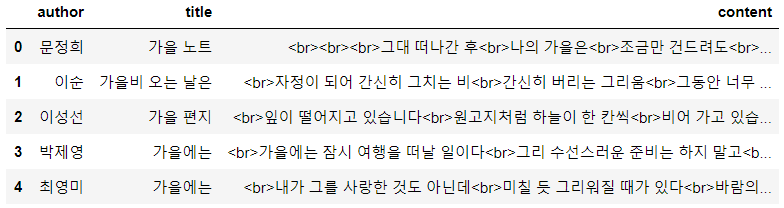

# 데이터 전처리

In [7]:
stopwords = [
    'stop', 'word'
]

In [11]:
from konlpy.tag import Okt
tagger = Okt()

# 시 내용 가져오기
contents = poem['content']

def preprocessing(text):
    # <br>제거
    text = text.replace("<br>", " ")
    
    # 형태소 분석
    okt_pos = tagger.pos(text, norm=True, stem=True)
    
    # 명사만 사용
    words = [word for word, hts in okt_pos if hts in ['Noun']]
    
    # 스탑 워드 적용
    words = [word for word in words if word not in stopwords]
    
    #리스트 문자열로 변경
    pure_string = ' '.join(words)
    
    return pure_string

content = list(contents.apply(preprocessing))

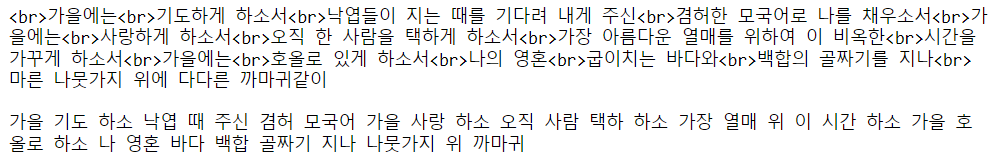

# tf-idf  
해도되고 안해도 되는데 결과가 잘안나와서 가중치 순위가 높은 단어로만 토픽 추출해보려고 함

In [13]:
"""
    idf는 전체적으로 자주 등장하는 단어를 가중치를 낮게 준다.
    EX) '당신'이라는 단어가 전체 글뭉치에서 빈도수가 높아 가중치를 낮게,
        '사과'라는 단어는 전체 글뭉치에서 빈도수가 낮아 가중치를 높게,
        즉 가중치가 높은 순서대로 각 글의 중심 단어임을 추측할 수 있음
"""
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
words_vectors = vectorizer.fit_transform(content).toarray()

words_vectors = pd.DataFrame(words_vectors)

In [14]:
def index_to_word(search_num):
    """tf-idf의 vocab이 매칭하는 숫자를 단어로 바꿔주는 함수,
       EX) 0번 단어 -> '사랑' 
    """
    words = vectorizer.vocabulary_
    
    for word, wordnum in words.items():
        if wordnum == search_num:
            return word

In [15]:
index_rank_datafarme = []

for index in range(len(words_vectors)):
    #각 row(각 편지)의 가중치가 높은 단어 정렬, 10개만 자름
    arow = words_vectors.iloc[index]
    arow = arow.sort_values(ascending=False)[0:10]
    
    # 숫자를 단어로 변경
    str_index = []
    for key, value in arow.items():
        if value != 0.0:
            str_index.append(index_to_word(key))
            
    index_rank_datafarme.append(str_index)

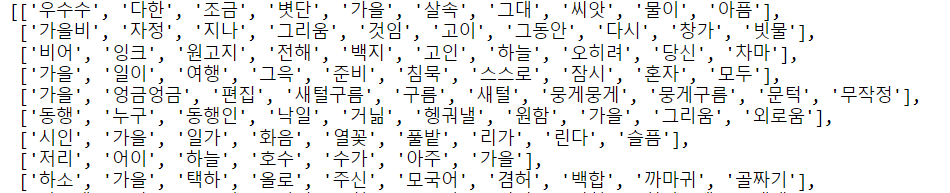

# 모델학습

In [19]:
from gensim import corpora

dictionary = corpora.Dictionary(index_rank_datafarme)
corpus = [dictionary.doc2bow(text) for text in index_rank_datafarme]

In [20]:
import gensim

NUM_TOPICS = 20  # 토픽 개수
ldamodel = gensim.models.ldamodel.LdaModel(
    corpus,
    num_topics=NUM_TOPICS,  #토픽 개수
    id2word=dictionary,
    passes=20,              # 전체 반복 횟수 == epoch
    iterations=400          # 한번 학습 반복 횟수 (iterations) * (passes)
)

# 검사

In [24]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence)
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))

"""
    Cpherence 값 작을 수록 좋음
    Perplexity값 클수록 좋음
"""

Cpherence -16.692855633024514

Perplexity:  -10.385748018127963


'\n    Cpherence 값 작을 수록 좋음\n    Perplexity값 클수록 좋음\n'

In [28]:
topics = ldamodel.print_topics(num_words=4) #num_words == 하나의 토픽당 가장 가중치가 높은 단어 개수의 출력 개수
topics

[(0, '0.050*"얼굴" + 0.032*"여자" + 0.029*"날개" + 0.024*"소리"'),
 (1, '0.034*"세상" + 0.025*"다시" + 0.024*"지금" + 0.023*"자신"'),
 (2, '0.028*"경전" + 0.028*"들고양이" + 0.028*"마스크" + 0.028*"사랑니"'),
 (3, '0.028*"가슴" + 0.026*"나무" + 0.022*"사이" + 0.021*"아무"'),
 (4, '0.036*"소리" + 0.030*"가지" + 0.027*"목소리" + 0.027*"방울"'),
 (5, '0.031*"어머니" + 0.029*"달이" + 0.028*"아아" + 0.027*"우물"'),
 (6, '0.025*"골목" + 0.024*"자꾸만" + 0.023*"입술" + 0.023*"언제"'),
 (7, '0.028*"눈동자" + 0.028*"아래" + 0.027*"당신" + 0.027*"높이"'),
 (8, '0.024*"상처" + 0.023*"흔적" + 0.023*"위로" + 0.023*"활짝"'),
 (9, '0.047*"사과" + 0.043*"대하" + 0.026*"그늘" + 0.025*"너머"'),
 (10, '0.050*"하나" + 0.034*"손가락" + 0.025*"당신" + 0.020*"아침"'),
 (11, '0.035*"바람" + 0.028*"기억" + 0.024*"어깨" + 0.024*"새벽"'),
 (12, '0.029*"오전" + 0.029*"심정" + 0.028*"참석" + 0.028*"증명"'),
 (13, '0.040*"허공" + 0.029*"하늘" + 0.028*"시간" + 0.027*"겨울"'),
 (14, '0.020*"먼저" + 0.020*"얼마나" + 0.019*"사실" + 0.019*"저리"'),
 (15, '0.037*"노래" + 0.028*"자꾸" + 0.028*"가면" + 0.025*"뼈마디"'),
 (16, '0.037*"생각" + 0.035*"편지" + 0.030*

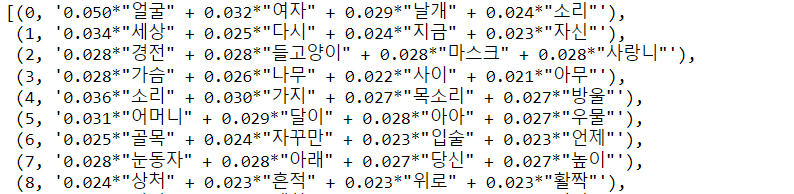

# epoch 계산
최적의 결과를 얻기 위해서 epoch수와 토픽의 개수를 계산하는게 좋다

In [29]:
coherences=[]
perplexities=[]
passes=[]

#range(진행할 횟수)
for i in range(10):
    
    #epoch 계산을 위해서 토픽 개수 고정
    ntopics, nwords = 26, 100
    
    #처음에는 epoch한번
    if i==0:
        p=1
    #이후에 5개씩 추가해서 결과 확인
    else:
        p=i*5
        
    lda4 = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=500, passes=p)
    print('epoch', p)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence) #작을수록 좋음
    coherences.append(coherence) #클수록 좋음
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexities.append(lda4.log_perplexity(corpus))

epoch 1
Cpherence -15.159336239454914
Perplexity:  -11.348140821189133 


epoch 5
Cpherence -16.494962219663257
Perplexity:  -10.79788570375723 


epoch 10
Cpherence -16.679659767449458
Perplexity:  -10.607125973230225 


epoch 15
Cpherence -17.20543621592389
Perplexity:  -10.52811490585829 


epoch 20
Cpherence -16.90742651477875
Perplexity:  -10.520046682660146 


epoch 25
Cpherence -17.19855349232277
Perplexity:  -10.484146018151561 




KeyboardInterrupt: 

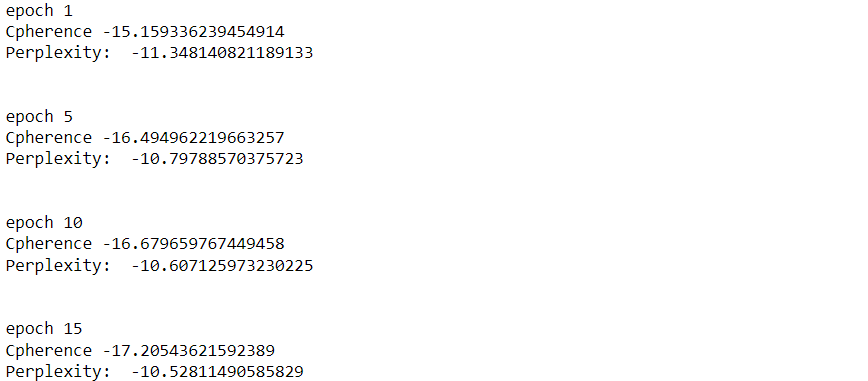

# 토픽 수 계산

In [30]:
coherences=[]
perplexities=[]
passes=[]

#range(진행할 횟수)
for i in range(10):
    
    #처음에는 토픽수 2개
    if i==0:
        ntopics = 2
    #이후에 5개씩 추가해서 결과 확인
    else:
        ntopics = 5*i
        
    lda4 = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=400, passes=35)
    print('ntopics', ntopics)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexities.append(lda4.log_perplexity(corpus))

ntopics 2
Cpherence -12.797280722120107
Perplexity:  -9.544418717011837 


ntopics 5
Cpherence -16.264394781976407
Perplexity:  -9.879243064213108 


ntopics 10
Cpherence -17.717474149293114
Perplexity:  -10.166943243972556 


ntopics 15
Cpherence -17.460091209969143
Perplexity:  -10.27172884848501 




KeyboardInterrupt: 

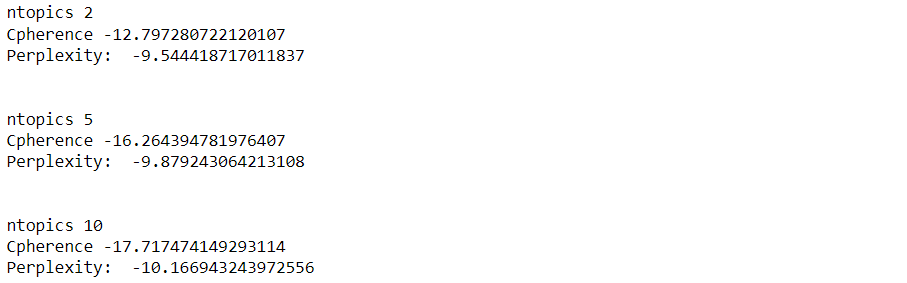

# 토픽 수기 작성용 파일 내보내기

In [261]:
"""
    LDA모델은 전체 입력데이터로부터 빈도수를 기반으로 토픽을 추출해준다.
    EX) 사랑이라는 단어가 전체적으로 많이 나오면 사랑이라는 키워드와 함께 나온 단어들을 묶어서 하나의 토픽으로 구분
    이때 토픽의 개수는 사람이 입력해주어야 한다
    
    또한 결과로 나온 토픽 역시 추출한 단어들을 보고 사람이 어떤 토픽인지 판단하는 과정이 필요하다
    EX) (10, '0.68*'점심' + '0.35*'김치' + '0.30*'밥' + '0.20*'잡곡' + '0.7*'젓가락')
    -> 10번 토픽은 밥, 식사, 음식, 요리 등의 이름으로 토픽 지정할 수 있음
"""

In [ ]:
NUMWORDS = 20 # 토픽당 내보낼 문자 개수

LDA_analysis = pd.DataFrame()
word_list = []
for index, onetopic in enumerate(ldamodel.show_topics(formatted=False, num_topics=ldamodel.num_topics, num_words=NUMWORDS)):

    for i in range(NUMWORDS):
        wordstring = ""
        for words in onetopic[1]:
            wordstring += words[0] + ","
            
    word_list.append(wordstring)
    
LDA_analysis[index] = word_list

In [ ]:
LDA_analysis.to_csv('poem_lda_topics.csv', index=False)

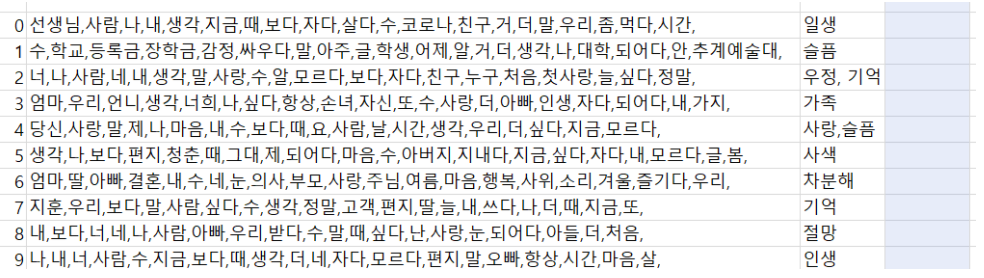  
수기로 토픽 작성

# 토픽 검사
토픽을 수기로 검사할 때 편지가 정말 해당 토픽에 해당하는지,  
같은 토픽에 묶인 편지들은 어떤 내용인지 등등  
실제로 편지의 내용을 확인하기 위한 참고 코드

In [31]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [36]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,1.0,0.9136,"[(1, 0.9135904)]"
1,1,5.0,0.7988,"[(1, 0.11935945), (5, 0.79877937)]"
2,2,10.0,0.9136,"[(10, 0.9135663)]"
3,3,19.0,0.4427,"[(1, 0.10251129), (12, 0.20277396), (17, 0.179..."
4,4,2.0,0.9136,"[(2, 0.913571)]"
...,...,...,...,...
2039,2039,15.0,0.4911,"[(2, 0.13165538), (9, 0.2710004), (15, 0.49109..."
2040,2040,6.0,0.4424,"[(5, 0.40764558), (6, 0.44235358)]"
2041,2041,4.0,0.5372,"[(4, 0.53723866), (8, 0.1974649), (12, 0.09682..."
2042,2042,19.0,0.5125,"[(0, 0.01250001), (1, 0.01250001), (2, 0.01250..."


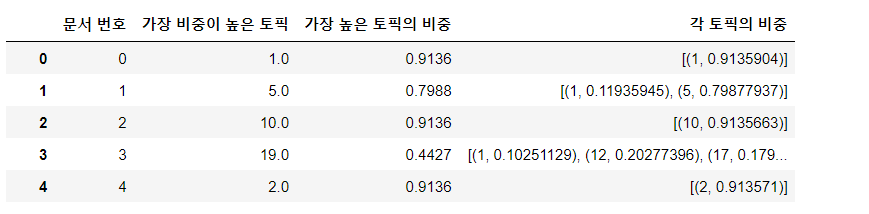

In [37]:
topic = 2.0 # 보고 싶은 토픽 넘버
topic_num = topictable[topictable['가장 비중이 높은 토픽'] == topic]['문서 번호']

In [40]:
a = [poem.iloc[rn].content for rn in topic_num]
print(len(a)) # 해당 토픽에 걸리는 시의 개수 출력
a[:30] # 해당 토픽에 걸리는 시 내용 출력

96


['<br>내가 그를 사랑한 것도 아닌데<br>미칠 듯 그리워질 때가 있다<br>바람의 손으로 가지런히 풀어놓은, 뭉게구름도 아니다<br>양떼구름도 새털구름도 아니다<br>아무 모양도 만들지 못하고 이리저리 찢어지는 구름을 보노라면<br>내가 그를 그리워한 것도 아닌데<br>그가 내 속에 들어온다<br>뭉게뭉게 피어나 양떼처럼 모여<br>새털처럼 가지런히 접히진 않더라도<br>유리창에 우연히 편집된 가을 하늘처럼<br>무작정 눈물이 날 때가 있다<br>가을에는, 오늘처럼 곱고 투명한 가을에는<br>이 세상에서 가장 슬픈 표정으로 문턱을 넘어와<br>엉금엉금, 그가 내 곁에 앉는다<br>그럴 때면 그만 허락하고 싶다<br>사랑이 아니라도, 그 곁에 키를 낮춰 눕고 싶다',
 '<br>오후 내내<br>나룻배를 타고<br>강기슭을 따라 내려갔습니다<br>당신이 너무 좋아하는 칡꽃 송이들이<br>푸른 강기슭을 따라 한없이 피어 있었습니다<br>하늘이 젖은 꿈처럼 수면 위에 잠기고<br>수면 위에 내려온 칡꽃들이<br>수심(水深) 한가운데서<br>부끄러운 옷을 벗었습니다<br>바람이 불고<br>바람이 불어가고<br>지천으로 흩날리는 꽃향기 속에서<br>내 작은 나룻배는<br>그만 길을 잃고 맙니다.',
 '<br>가끔씩은 흔들려보는 거야<br>흐르는 눈물을 애써 막을 필요는 없어<br>그냥 내 슬픔을 보여주는 거야<br>자신에게까지 숨길 필요는 없어<br>물이 고이면 썩어들어가는 것처럼<br>작은 상심이 절망이 될 때까지 쌓아둘 필요는 없어<br>상심이 커져가 그것이 넘쳐날 땐<br>스스로 비울 수 있는 힘도 필요한 거야<br>삶이 흔들리는 건<br>아직도 흘릴 눈물이 남았다는 건<br>내 삶을 포기하지 않는다는 증거니까<br>가끔씩은 흔들려보는 거야<br>하지만 허물어지면 안 돼<br>지금 내게 기쁨이 없다고<br>모든 걸 포기할 필요는 없어<br>늦게 찾아온 기쁨은 그만큼 늦게 떠나가니까',
 '<br>사랑하는 사람에게선<br>가장 아름다운 여인이고 싶고<br>떠나

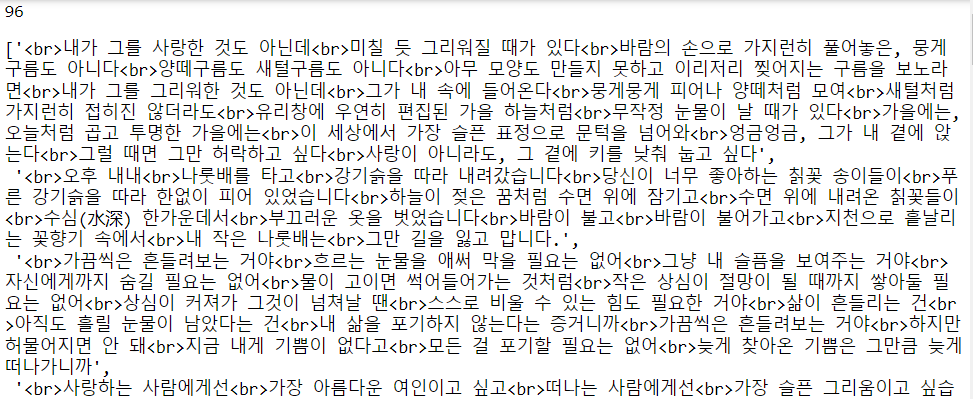

# 결과 CSV 파일 내보내기
각 시에 해당하는 토픽을 레이블링한 CSV 결과 파일 내보내기

In [44]:
poem_dataframe = pd.DataFrame()
poem_dataframe['author'] = poem['author']
poem_dataframe['title'] = poem['title']

In [45]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame(columns = [0,1,2])

    # 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list    
         # 가장 높은 확률로 매칭되는 토픽을 확인하기 위해 토픽 가중치 내림차순으로 정렬
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        
        topic_list = []
        for j, (topic_num, prop_topic) in enumerate(doc):
            # 편지의 토픽 가중치, 즉 토픽에 해당하는 확률이 20%가 넘는 토픽만 레이블링함
            if prop_topic >= 0.20:
                # 분류된 단어들이 너무 공통점이 없어서 토픽 클래스를 분류하지 못한 토픽은 제외
                if topic_num not in (1, 5, 11, 14, 15, 17, 20, 24, 29, 33, 35, 36, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 53, 56, 58, 59, 61, 68):
                    topic_list.append(topic_num)
            if j == 2:
                break
        
        # 시를 데이터 형변환 후 단어가 2개 이하인 경우 남은 컬럼을 -1로 채워줌
        # 데이터 프레임을 만들때 컬럼수가 다르면 만들 수 없기 때문에 처리
        for index in range(3):
            if len(topic_list) < 3:
                topic_list.append(-1)

        topic_table.loc[i] = topic_list
    return(topic_table)

In [46]:
topictable = make_topictable_per_doc(ldamodel, corpus)

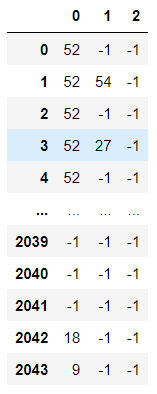

In [48]:
topictable.to_csv('poem_LDA_ranking_more_20P.csv', index=False)